In [567]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

In [568]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [569]:
data_path = 'C:\\Users\\sunil\\Projects\\Analytics vidya\\Finhack\\Data\\'
submission_path = 'C:\\Users\\sunil\\Projects\\Analytics vidya\\Finhack\\Data\\submission\\'

In [570]:
pd.set_option('display.max_columns', 100)

In [571]:
%%time
train_data = pd.read_excel(data_path + 'Train\\Train\\train_Data.xlsx')
train_bureau = pd.read_excel(data_path + 'Train\\Train\\train_bureau.xlsx')

test_data = pd.read_excel(data_path + 'Test\\test_Data.xlsx')
test_bureau = pd.read_excel(data_path + 'Test\\test_bureau.xlsx')

Wall time: 2min 20s


In [572]:
sample_sub = pd.read_csv(data_path + 'sample_submission_ejm25Dc.csv')

In [573]:
target = 'Top-up Month'

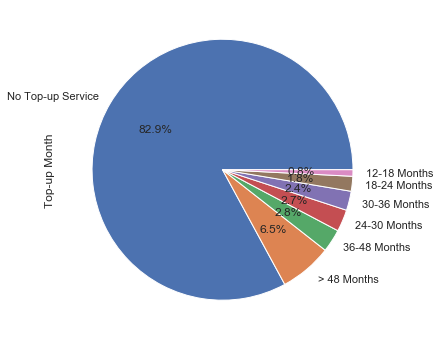

In [574]:
plt.figure(figsize = (6, 6))
train_data[target].value_counts().plot.pie(autopct = '%1.1f%%')

# Filling Missing Values in Train_data & Test Data

In [575]:
df = pd.concat([train_data, test_data], axis = 0).reset_index(drop = True)

1. Zipcode

In [576]:
area_ls = list(df[ df['ZiPCODE'].isna()]['Area'].unique())
zip_no = [float(i) for i in range(1, 43)]

zip_area_dict = dict(zip(area_ls, zip_no))

In [577]:
df.loc[ df['ZiPCODE'].isna(),'ZiPCODE'] = df.loc[ df['ZiPCODE'].isna()]['Area'].apply(lambda x: zip_area_dict[x])

2. City

In [578]:
city_zip_dict = df.groupby('ZiPCODE')['City'].apply(pd.Series.mode).to_dict()

In [579]:
def impute_city(x):
    try:
        return city_zip_dict[ (x, 0)]
    except KeyError:
        return None

In [580]:
df.loc[ df['City'].isna(), 'City'] = df[ df['City'].isna()]['ZiPCODE'].apply(lambda x : impute_city(x))

3. Area

In [581]:
area_city_dict = df.groupby('City')['Area'].apply(pd.Series.mode).to_dict()

In [582]:
def impute_area(x):
    try:
        return area_city_dict[ (x, 0)]
    except KeyError:
        return None

In [583]:
df.loc[ df['Area'].isna(), 'Area'] = df[ df['Area'].isna()]['City'].apply(lambda x : impute_area(x))

2. City

In [584]:
city_area_dict = df.groupby('Area')['City'].apply(pd.Series.mode).to_dict()

In [585]:
def impute_city(x):
    try:
        return city_area_dict[ (x, 0)]
    except KeyError:
        return None

In [586]:
df.loc[ df['City'].isna(), 'City'] = df[ df['City'].isna()]['Area'].apply(lambda x : impute_city(x))

In [587]:
# Imputing Remaining Areas and Cities

In [588]:
zp_ls = list(df[ df['Area'].isna()]['ZiPCODE'].unique())
ls = [str(i) for i in range(1, 101)]

zp_ar_ct = dict(zip(zp_ls, ls))

In [589]:
df.loc[ df['Area'].isna(), ['Area', 'City']] = df[ df['Area'].isna()]['ZiPCODE'].apply(lambda x: zp_ar_ct[x])

In [590]:
# MaturityDAte 
df.loc[ df['MaturityDAte'].isna(), 'MaturityDAte'] = '2015-12-10'

In [591]:
df['SEX'].fillna(value = df['SEX'].mode()[0], inplace = True)
df['AGE'].fillna(value = df['AGE'].median(), inplace = True)
df['MonthlyIncome'].fillna(value = df['MonthlyIncome'].median(), inplace = True)
df['ManufacturerID'].fillna(value = df['ManufacturerID'].mode()[0], inplace = True)

In [592]:
cleaned_train_data, cleaned_test_data = df[:train_data.shape[0]], df[train_data.shape[0]:]

df['BranchID'] = df['BranchID'].astype('int16')
df['Tenure'] = df['Tenure'].astype('int16')
df['AssetCost'] = df['AssetCost'].astype('int32')
df['AmountFinance'] = df['AmountFinance'].astype('int32')
df['DisbursalAmount'] = df['DisbursalAmount'].astype('int32')
df['AssetID'] = df['AssetID'].astype('int32')
df['ManufacturerID'] = df['ManufacturerID'].astype('int16')
df['SupplierID'] = df['SupplierID'].astype('int32')
df['AGE'] = df['AGE'].astype('int8')
df['MonthlyIncome'] = df['MonthlyIncome'].astype('int32')
df['ZiPCODE'] = df['ZiPCODE'].astype('int32')

In [593]:
cleaned_train_data.to_csv(data_path + 'Cleaned\\cleaned_train_data.csv', index = False)
cleaned_test_data.to_csv(data_path + 'Cleaned\\cleaned_test_data.csv', index = False)

---
# Cleaning Train, Test Bureau

In [594]:
train_bureau.isna().sum()/train_bureau.shape[0]*100

ID                            0.000000
SELF-INDICATOR                0.000000
MATCH-TYPE                    0.000000
ACCT-TYPE                     0.000000
CONTRIBUTOR-TYPE              0.000000
DATE-REPORTED                 0.656689
OWNERSHIP-IND                 0.000000
ACCOUNT-STATUS                0.000000
DISBURSED-DT                  5.732432
CLOSE-DT                     44.889131
LAST-PAYMENT-DATE            56.929021
CREDIT-LIMIT/SANC AMT        97.297109
DISBURSED-AMT/HIGH CREDIT     0.000000
INSTALLMENT-AMT              74.977890
CURRENT-BAL                   0.041545
INSTALLMENT-FREQUENCY        75.802719
OVERDUE-AMT                  21.198586
WRITE-OFF-AMT                 3.409683
ASSET_CLASS                  53.557852
REPORTED DATE - HIST          3.409683
DPD - HIST                    3.503113
CUR BAL - HIST                3.409683
AMT OVERDUE - HIST            3.409683
AMT PAID - HIST               3.618475
TENURE                       65.634472
dtype: float64

In [595]:
test_bureau.isna().sum()/train_bureau.shape[0]*100

ID                            0.000000
SELF-INDICATOR                0.000000
MATCH-TYPE                    0.000000
ACCT-TYPE                     0.000000
CONTRIBUTOR-TYPE              0.000000
DATE-REPORTED                 0.000000
OWNERSHIP-IND                 0.000000
ACCOUNT-STATUS                0.000000
DISBURSED-DT                  0.007845
CLOSE-DT                      5.608155
LAST-PAYMENT-DATE             5.803753
CREDIT-LIMIT/SANC AMT        11.129833
DISBURSED-AMT/HIGH CREDIT     0.006776
INSTALLMENT-AMT               8.503791
CURRENT-BAL                   0.005706
INSTALLMENT-FREQUENCY         8.601857
OVERDUE-AMT                   2.340580
WRITE-OFF-AMT                 0.456633
ASSET_CLASS                   6.223121
REPORTED DATE - HIST          0.456633
DPD - HIST                    0.457346
CUR BAL - HIST                0.456633
AMT OVERDUE - HIST            0.456633
AMT PAID - HIST               0.476425
TENURE                        7.645976
dtype: float64

In [712]:
df = pd.concat([train_bureau, test_bureau], axis = 0).reset_index(drop = True)

1. Filling missing Values in Date Reported

1st date in reported date hist is reported date

In [713]:
drop_index = df[ (df['DATE-REPORTED'].isna()) & (df['REPORTED DATE - HIST'].isna())].index
df.drop(drop_index, inplace = True, axis = 0)

In [714]:
def date_imputer(x):
    x = str(x)
    temp = x.split(',')[0]
    temp = [i for i in temp]
    temp.insert(4, '-')
    temp.insert(7, '-')
    out = ''.join(temp)
    return out

In [715]:
df.loc[df['DATE-REPORTED'].isna(), 'DATE-REPORTED'] = df['REPORTED DATE - HIST'].apply(lambda x: date_imputer(x))

In [716]:
df.loc[ df['DISBURSED-DT'].isna(), 'DISBURSED-DT'] = df[ df['DISBURSED-DT'].isna()]['DATE-REPORTED'].apply(lambda x: str(x)[:9])

2. CLOSE-DT

In [717]:
# filling missing values in CLose-DT
df.loc[ (df['CLOSE-DT'].isna()) & (df['ACCOUNT-STATUS'] != 'Delinquent') & (df['ACCOUNT-STATUS'] != 'Active') & (~df['LAST-PAYMENT-DATE'].isna()), 'CLOSE-DT'] = df.loc[ (df['CLOSE-DT'].isna()) & (df['ACCOUNT-STATUS'] != 'Delinquent') & (df['ACCOUNT-STATUS'] != 'Active') & (~df['LAST-PAYMENT-DATE'].isna())]['LAST-PAYMENT-DATE']

In [698]:
a = df[ (df['ACCOUNT-STATUS'] != 'Active') & (df['ACCOUNT-STATUS'] != 'Delinquent') & (df['CLOSE-DT'].isna())].ID.unique()

In [699]:
b = df[ (~df['CLOSE-DT'].isna()) & (df['ACCOUNT-STATUS'] != 'Active') & (df['ACCOUNT-STATUS'] != 'Delinquent')].ID.unique()

In [726]:
len(df[ ~df['CREDIT-LIMIT/SANC AMT'].isna()].ID.unique())

7688

In [728]:
df.isna().sum()

ID                                0
SELF-INDICATOR                    0
MATCH-TYPE                        0
ACCT-TYPE                         0
CONTRIBUTOR-TYPE                  0
DATE-REPORTED                     0
OWNERSHIP-IND                     0
ACCOUNT-STATUS                    0
DISBURSED-DT                      0
CLOSE-DT                     280445
LAST-PAYMENT-DATE            351783
CREDIT-LIMIT/SANC AMT        608009
DISBURSED-AMT/HIGH CREDIT        38
INSTALLMENT-AMT              468136
CURRENT-BAL                     265
INSTALLMENT-FREQUENCY        473269
OVERDUE-AMT                  132015
WRITE-OFF-AMT                 21575
ASSET_CLASS                  335169
REPORTED DATE - HIST          21575
DPD - HIST                    22103
CUR BAL - HIST                21575
AMT OVERDUE - HIST            21575
AMT PAID - HIST               22857
TENURE                       410922
dtype: int64

In [744]:
df

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30 00:00:00,Individual,Delinquent,2015-10-05 00:00:00,NaN,2018-02-27,NaN,"37,352",NaN,"37,873",NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31 00:00:00,Individual,Active,2018-03-19 00:00:00,NaN,2019-12-19,NaN,"44,000","1,405/Monthly","20,797",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31 00:00:00,Individual,Active,2019-08-30 00:00:00,NaN,NaT,NaN,"1,45,000",NaN,"1,16,087",NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30 00:00:00,Individual,Closed,2013-09-27 00:00:00,2017-09-21 00:00:00,NaT,NaN,"3,00,000",NaN,0,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29 00:00:00,Individual,Closed,2012-02-10 00:00:00,2016-02-01 00:00:00,NaT,NaN,"2,75,000",NaN,0,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624858,143400,False,PRIMARY,Construction Equipment Loan,PRB,2019-10-31 00:00:00,Joint,Active,2017-04-12 00:00:00,NaN,2019-10-16,NaN,"12,30,000",NaN,"2,04,173",NaN,0,0.0,Standard,"20191031,20190930,20190831,20190731,20190630,2...",0000000000000000000000000000000000000000000000...,"204173,243754,282926,321694,360063,398035,4356...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","42120,42120,42120,42120,42120,42120,42120,4212...",NaN
624859,143400,False,PRIMARY,Commercial Vehicle Loan,PRB,2018-02-28 00:00:00,Joint,Closed,2015-05-16 00:00:00,2018-02-24 00:00:00,2018-02-24,NaN,"20,00,000",NaN,0,NaN,0,0.0,Standard,"20180228,20180131,20171231,20171130,20171031,2...",0000000000000000000000000000000000000000000000...,"0,0,0,0,0,0,0,0,0,0,0,100494,200014,298570,396...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","1796,0,0,0,0,0,0,0,0,0,101475,101475,101475,10...",NaN
624860,143400,False,PRIMARY,Construction Equipment Loan,PRB,2019-10-31 00:00:00,Joint,Active,2017-04-12 00:00:00,NaN,2019-10-16,NaN,"10,80,000",NaN,"1,79,276",NaN,0,0.0,Standard,"20191031,20190930,20190831,20190731,20190630,2...",0000000000000000000000000000000000000000000000...,"179276,214030,248425,282466,316155,349498,3824...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","36984,36984,36984,36984,36984,36984,36984,3698...",NaN
624861,143400,True,PRIMARY,Tractor Loan,NBF,2014-08-31 00:00:00,Individual,Closed,2013-05-28 00:00:00,2014-08-31 00:00:00,NaT,NaN,"3,10,000",NaN,0,NaN,0,0.0,NaN,"20140831,20140731,20140630,20140531,20140430,2...",000000000000000000000000000000000000000000000000,"0,0,0,27840,55324,82457,109244,135689,161796,1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",",,,,,,,,,,,,,,,,,",NaN
